# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType
from pyspark.sql.functions import col, month, year, isnan, desc, unix_timestamp, to_timestamp, dayofmonth, hour, minute, second
from functools import reduce
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /scratch/hradhakrishnan/job_30371804/matplotlib-qbh__u21 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Setting up a theme with Seaborn
sns.set_theme(style="whitegrid")

# Adjusting font scale for better readability
sns.set_context("notebook", font_scale=1.2)

In [3]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Yellow Taxi EDA") \
    .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
# spark = SparkSession.builder \
#     .config("spark.driver.memory", "8g") \
# 	.config("spark.executor.memory", "4g") \
#     .config('spark.executor.instances', 6) \
# 	.appName("Yellow Taxi EDA") \
# 	.getOrCreate()

In [4]:
spark

# Importing Data

In [20]:
# base_path = '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'

paths = ['yellow_taxi_data/yellow_tripdata_2023-01.parquet', 'yellow_taxi_data/yellow_tripdata_2023-02.parquet']

# for mo in range(1, 7):  # This loops from 1 to 12
#     path = base_path.format(mo)  # Formats the month with leading zero if necessary
#     paths.append(path)

In [21]:
spark.read.parquet('yellow_taxi_data/yellow_tripdata_2023-01.parquet')

DataFrame[VendorID: bigint, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double]

In [22]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [23]:
df.count()

5980721

In [24]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [ ]:
# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

In [ ]:
# Dictionary to hold the column names and their corresponding counts of missing values
missing_counts = {}

# Calculate missing values for each column, taking data type into consideration
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    missing_counts[col_name] = missing_count

# Convert the dictionary to a Pandas DataFrame for displaying as a table
missing_counts_df = pd.DataFrame(list(missing_counts.items()), columns=['Column Name', 'Missing Values'])

# Display the DataFrame as a table
print(missing_counts_df)

In [7]:
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)
        correlation_matrix.loc[col1, col2] = corr_value

# Convert entries from object to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Plotting the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Fields')
plt.show()

NameError: name 'numeric_cols' is not defined

In [8]:
# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()

NameError: name 'df' is not defined

In [9]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.15, withReplacement=False)

NameError: name 'df' is not defined

In [48]:
def filter_quantile_range(df, col_names, lower_quantile=0.01, upper_quantile=0.99):
    """
    Filter data in the DataFrame based on the specified quantile range for given columns.

    Parameters:
        df (DataFrame): The input DataFrame to filter.
        col_names (list): List of column names to filter on.
        lower_quantile (float): The lower quantile bound (e.g., 0.1 for the 10th percentile).
        upper_quantile (float): The upper quantile bound (e.g., 0.9 for the 90th percentile).

    Returns:
        DataFrame: The filtered DataFrame within the specified quantile range.
    """
    # Initialize an empty list to store the filter conditions
    conditions = []
    
    for column_name in col_names:
        # Get the quantile bounds for the column
        lower_bound, upper_bound = df.approxQuantile(column_name, [lower_quantile, upper_quantile], 0.01)
        
        # Create a condition to filter data within the quantile range for this column
        condition = (col(column_name) >= lower_bound) & (col(column_name) <= upper_bound)
        conditions.append(condition)
    
    # Combine all the conditions using AND (every column must meet its own condition)
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition &= condition
    
    # Filter the DataFrame based on the combined condition
    filtered_df = df.filter(combined_condition)
    
    return filtered_df

# Total Amount

In [190]:
filtered_df = filter_quantile_range(sampled_df, ["total_amount", "tip_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [191]:
pandas_df = filtered_df.select("total_amount", "tip_amount").toPandas()

In [193]:
cleaneddf = pandas_df[(pandas_df['total_amount']>0) & (pandas_df['tip_amount']>0) & (pandas_df['tip_amount']<12) & (pandas_df['total_amount']<60)]

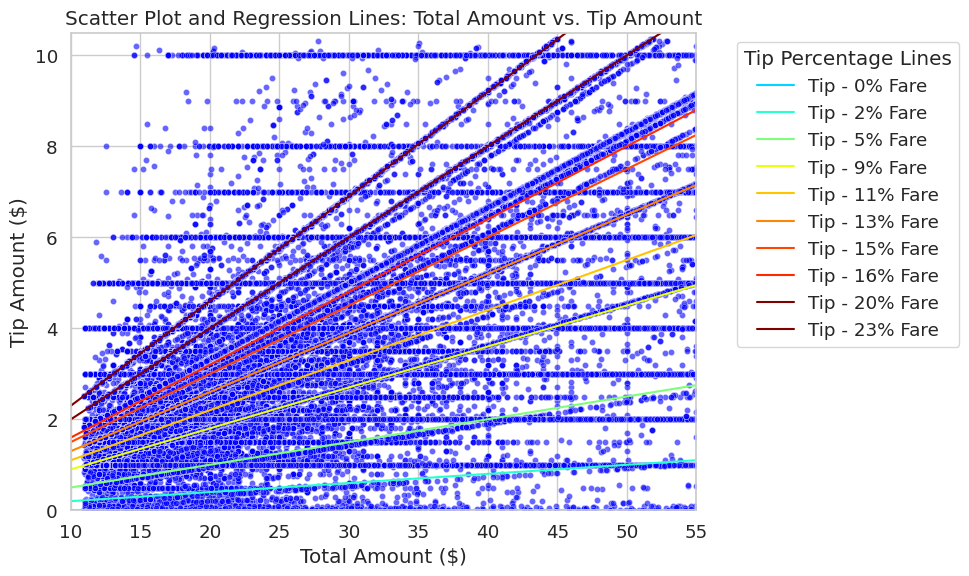

In [222]:
slopes = [0,2,5,9,11,13,15, 16,20, 23]
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_amount', y='tip_amount', data=cleaneddf, color='blue', alpha=0.6, s=20)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'Tip - {slope}% Fare', color=plt.cm.jet((slope+10) / 30)) 

plt.title('Scatter Plot and Regression Lines: Total Amount vs. Tip Amount')
plt.xlabel('Total Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage Lines', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([10,55])
plt.tight_layout()
plt.show()

## 1. Fare amount vs Tip Amount

In [227]:
filtered_df = filter_quantile_range(sampled_df, ["fare_amount", "tip_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [228]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.select("fare_amount", "tip_amount").toPandas()

In [232]:
cleaneddf = pandas_df[(pandas_df['fare_amount']>0) & (pandas_df['tip_amount']>0) & (pandas_df['tip_amount']<12) & (pandas_df['fare_amount']<60)]

In [233]:
filtered_df.groupBy("tip_amount").count().orderBy("count", ascending=False).show(10)

+----------+------+
|tip_amount| count|
+----------+------+
|       0.0|165096|
|       2.0| 43415|
|       1.0| 36461|
|       3.0| 22073|
|       2.8| 11453|
|       5.0| 10261|
|       3.5| 10255|
|       4.0|  9637|
|       1.5|  9434|
|       2.1|  9180|
+----------+------+
only showing top 10 rows



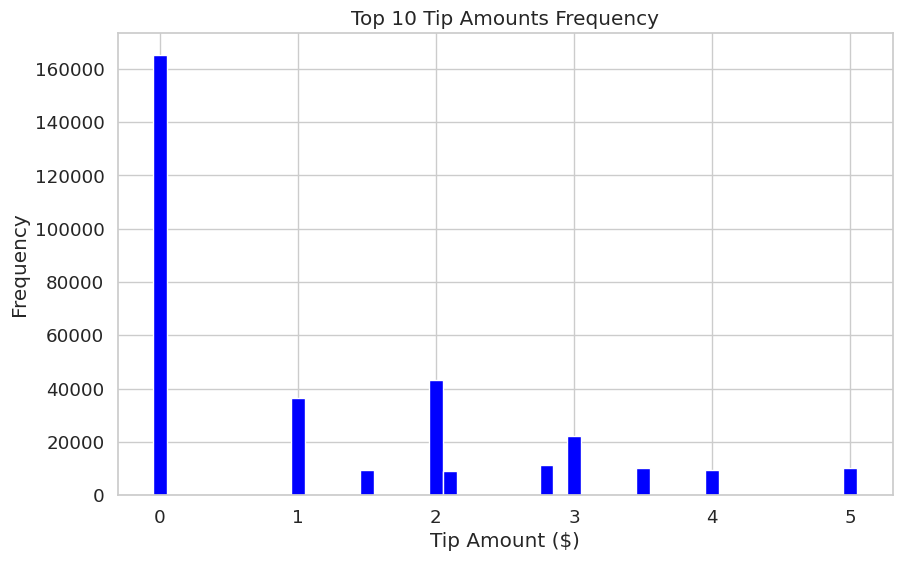

In [234]:
# Harin - tip amount by freq
tip_counts_df = filtered_df.groupBy("tip_amount").count().orderBy("count", ascending=False).limit(10)

tip_amounts, counts = zip(*tip_counts_df.rdd.map(lambda row: (row['tip_amount'], row['count'])).collect())

plt.figure(figsize=(10, 6))
plt.bar(tip_amounts, counts, color='blue', width = 0.1)
plt.title('Top 10 Tip Amounts Frequency')
plt.xlabel('Tip Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [235]:
# plt.figure(figsize=(10, 6))
# sns.lmplot(x='fare_amount', y='tip_amount', data=cleaneddf, )
# plt.title('LM Plot of Fare Amount vs. Tip Amount')
# plt.xlabel('Fare Amount ($)')
# plt.ylabel('Tip Amount ($)')
# plt.show()

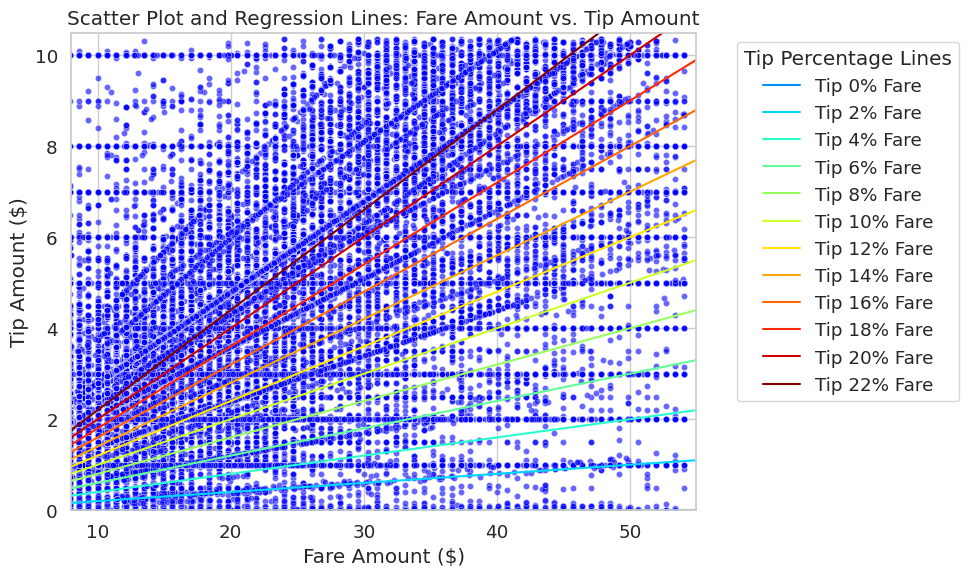

In [237]:
#Harin - Assumed const Tip % -turns out it wasn't, still not sure why there's a pattern
#intercept can account for taxes - maybe
slopes = np.arange(0, 24, 2)  
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=cleaneddf, color='blue', alpha=0.6, s=20)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'Tip {slope}% Fare', color=plt.cm.jet((slope+8) / 30)) 
plt.title('Scatter Plot and Regression Lines: Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage Lines', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([8,55])
plt.tight_layout()
plt.show()

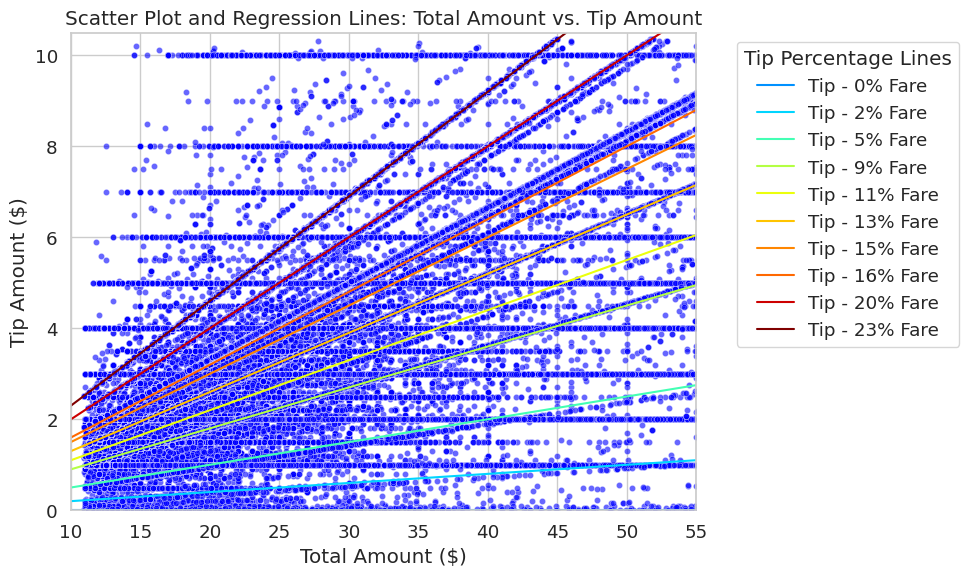

In [224]:
# seems ther's a correlation between tip and total amount, not fare amount

slopes = [0,2,5,9,11,13,15, 16,20, 23]
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_amount', y='tip_amount', data=cleaneddf, color='blue', alpha=0.6, s=20)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'Tip - {slope}% Fare', color=plt.cm.jet((slope+8) / 30)) 

plt.title('Scatter Plot and Regression Lines: Total Amount vs. Tip Amount')
plt.xlabel('Total Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage Lines', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([10,55])
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


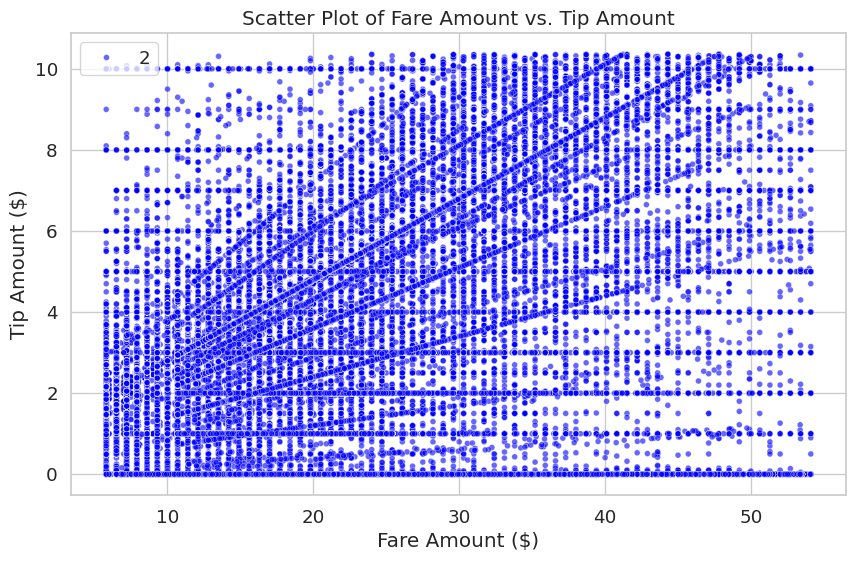

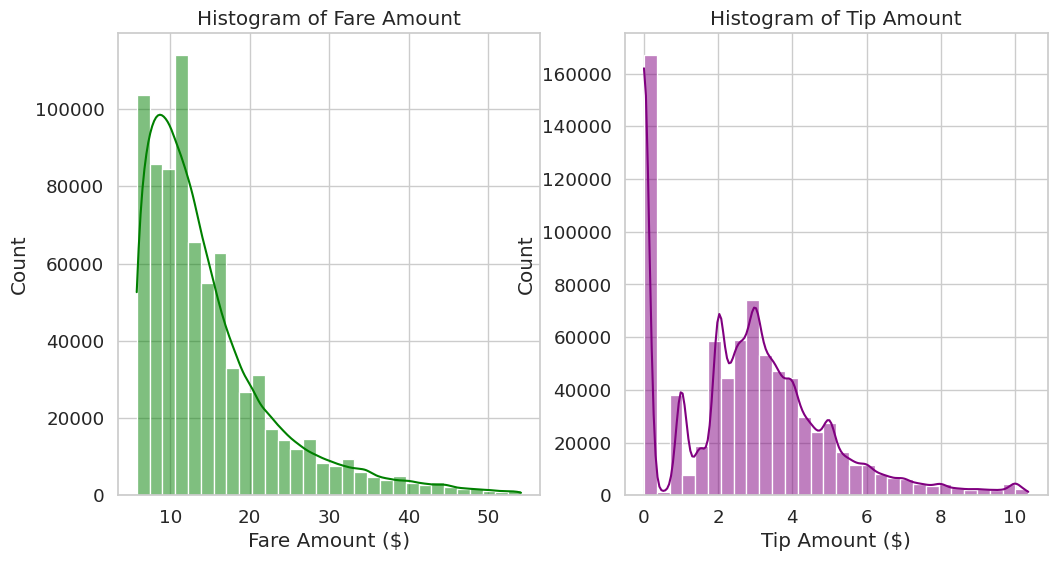

In [51]:
# Boxplot for fare_amount and tip_amount
plt.figure(figsize=(12, 6))

# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['fare_amount'], kde=True, bins=30, color='green')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')

plt.subplot(1, 2, 2)
sns.histplot(pandas_df['tip_amount'], kde=True, bins=30, color='purple')
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount ($)')
plt.show()

In [52]:
# Filter for negative fares and tips, group by payment type
negative_fares_tips = df.filter((col("fare_amount") < 0) | (col("tip_amount") < 0))

In [53]:
negative_fares_tips.groupBy("payment_type").count().show()

+------------+-----+
|payment_type|count|
+------------+-----+
|           0|  130|
|           1|   38|
|           3| 9171|
|           2|11373|
|           4|29110|
+------------+-----+



In [54]:
# Group by RateCodeID for entries with negative fares or tips
negative_fares_tips.groupBy("RateCodeID").count().show()

+----------+-----+
|RateCodeID|count|
+----------+-----+
|      NULL|  130|
|       1.0|44829|
|       4.0|  143|
|       3.0|  572|
|       2.0| 3341|
|       5.0|  807|
+----------+-----+



In [55]:
# Extract year and month, then analyze counts of negative values
negative_fares_tips.withColumn("year", year("tpep_pickup_datetime")) \
    .withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    1|25052|
|2023|    2|24770|
+----+-----+-----+



## 2. Trip Duration vs. Distance

In [56]:
# #Collect duration data
# time_difference_seconds = sampled_df.withColumn("time_difference_seconds",
#                    (col("tpep_dropoff_datetime") - col("tpep_pickup_datetime"))).collect()
                   
# time_difference_seconds_values = [row.time_difference_seconds.total_seconds() for row in time_difference_seconds]

# #Collect trip distance data
# trip_distance = sampled_df.select("trip_distance").collect()
# trip_distance_values = [row[0] for row in trip_distance]

In [238]:
# Calculate the time difference in seconds using unix_timestamp
filtered_df = sampled_df.withColumn(
    "trip_duration_seconds",
    unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))
)

# filter using quantile range function based on time_difference_seconds
filtered_df = filter_quantile_range(filtered_df, ["trip_duration_seconds", "trip_distance"], 0.05, 0.95)

In [239]:
pandas_df = filtered_df.select("trip_duration_seconds", "trip_distance").toPandas()


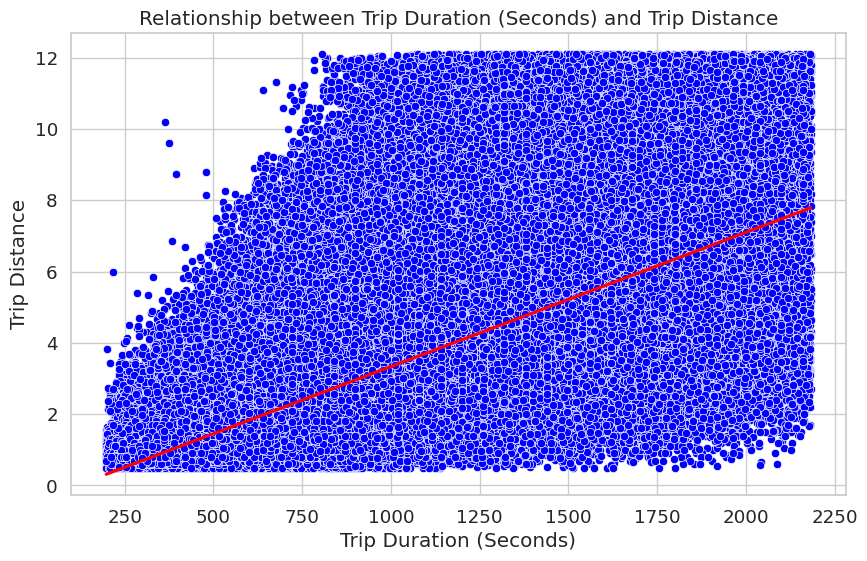

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='blue')
sns.regplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, scatter=False, color='red', ci=None)
plt.title("Relationship between Trip Duration (Seconds) and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()


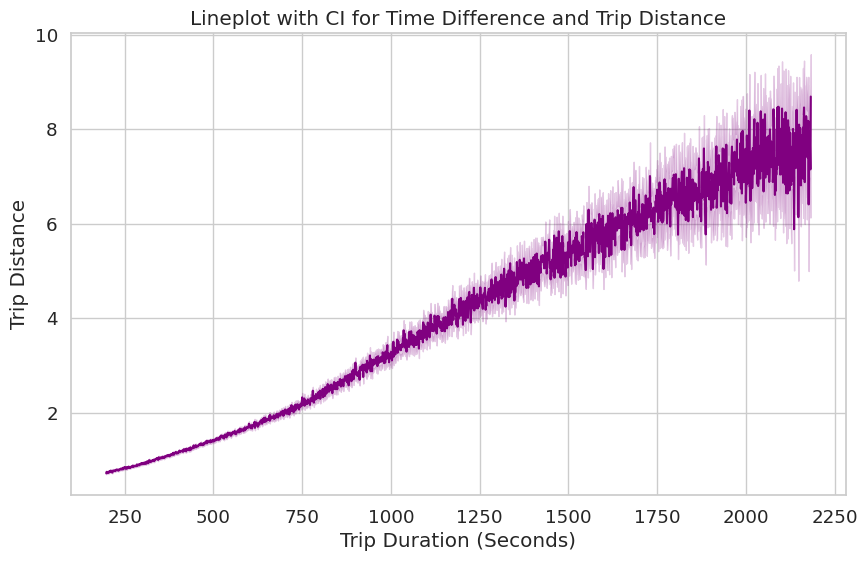

In [244]:
# Harin - Lineplot with confidence Intervals

plt.figure(figsize=(10, 6))
sns.lineplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='purple')
plt.title("Lineplot with CI for Time Difference and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

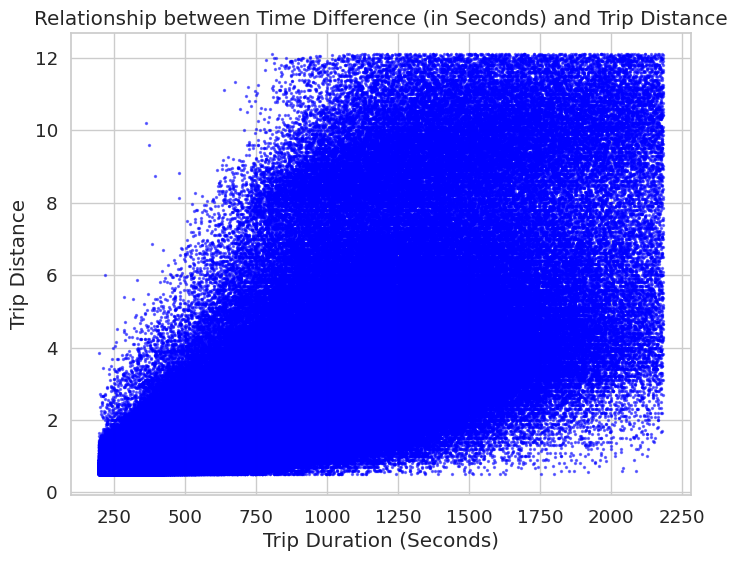

In [59]:
#X/Y plot
plt.figure(figsize=(8, 6))
plt.scatter(x = "trip_duration_seconds", y= "trip_distance", data= pandas_df, color='blue', s=2, alpha=0.5)
plt.title("Relationship between Time Difference (in Seconds) and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

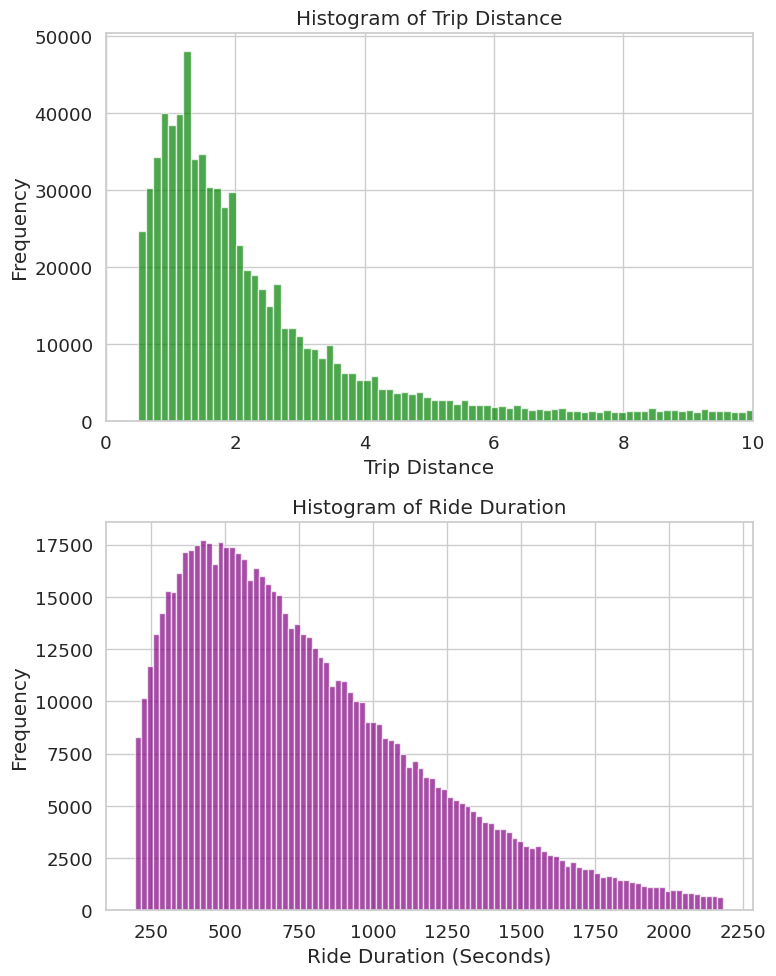

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Histogram for trip distance
axs[0].hist(pandas_df["trip_distance"], bins=100,  color='green', alpha=0.7)
axs[0].set_title('Histogram of Trip Distance')
axs[0].set_xlabel('Trip Distance')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 10)
axs[0].grid(True)

# Histogram for ride duration
axs[1].hist(pandas_df["trip_duration_seconds"], bins=100, color='purple', alpha=0.7)
axs[1].set_title('Histogram of Ride Duration')
axs[1].set_xlabel('Ride Duration (Seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Trends by hour of day

In [61]:
sampled_df_time = sampled_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
sampled_df_time = sampled_df_time.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime"))

sampled_df_time.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|year|month|day|hour|minute|second|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|       2| 2023-01-01 00:55:08|  2023-01-01 01:01:27|            1.0|          1.1|  

In [62]:
pandas_time_df = sampled_df_time.select("year","month","day","hour","minute","second","Extra","fare_amount", "trip_distance").toPandas()
pandas_time_df['Amount_per_Distance'] = pandas_time_df["fare_amount"]/pandas_time_df["trip_distance"]
pandas_time_df

year  month  day  hour  minute  second  Extra  fare_amount  \
0       2023      1    1     0      55       8    1.0         7.90   
1       2023      1    1     0      13       4    1.0        10.00   
2       2023      1    1     0      45      11    1.0        19.80   
3       2023      1    1     0      40      13    3.5         5.10   
4       2023      1    1     0      31      30    3.5        19.10   
...      ...    ...  ...   ...     ...     ...    ...          ...   
897753  2023      2   28    23      51       0    0.0        20.76   
897754  2023      2   28    23      46      55    0.0        13.91   
897755  2023      2   28    23       7      46    0.0        34.53   
897756  2023      2   28    23      41      22    0.0        20.03   
897757  2023      2   28    23      24       0    0.0        17.64   

        trip_distance  Amount_per_Distance  
0                1.10             7.181818  
1                1.52             6.578947  
2                2.23             8.878924  
3                0.70             7.285714  
4                4.10             4.658537  
...               ...                  ...  
897753           4.69             4.426439  
897754           2.38             5.844538  
897755          10.48             3.294847  
897756           4.71             4.252654  
897757           3.49             5.054441  

[897758 rows x 10 columns]

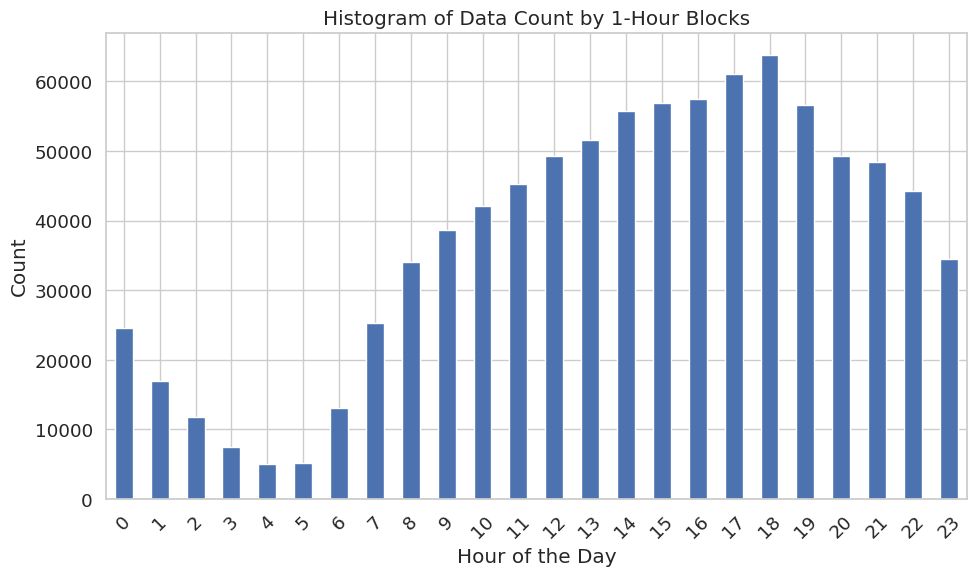

In [63]:
time_block_counts = pandas_time_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
time_block_counts.plot(kind='bar')
plt.title('Histogram of Data Count by 1-Hour Blocks')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

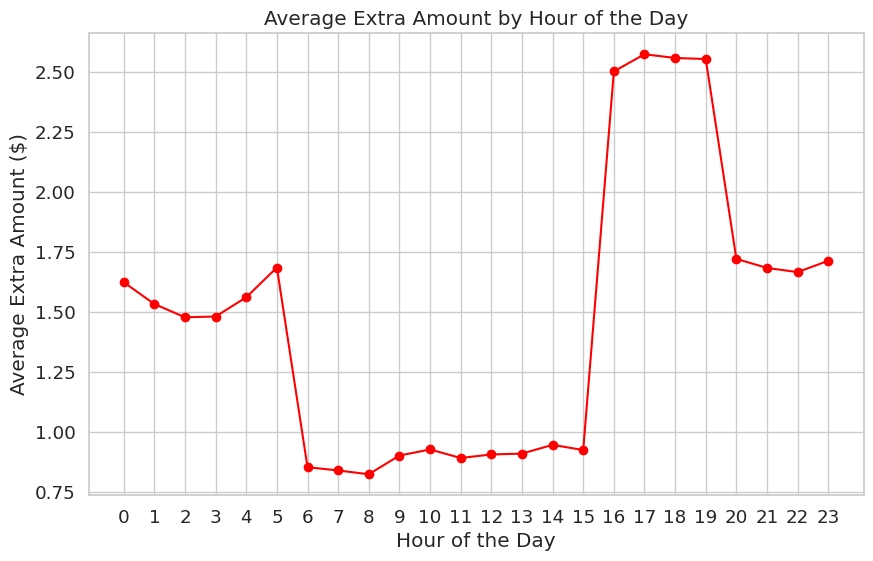

In [64]:
hourly_avg = pandas_time_df.groupby('hour')['Extra'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='red')
plt.title('Average Extra Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Extra Amount ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

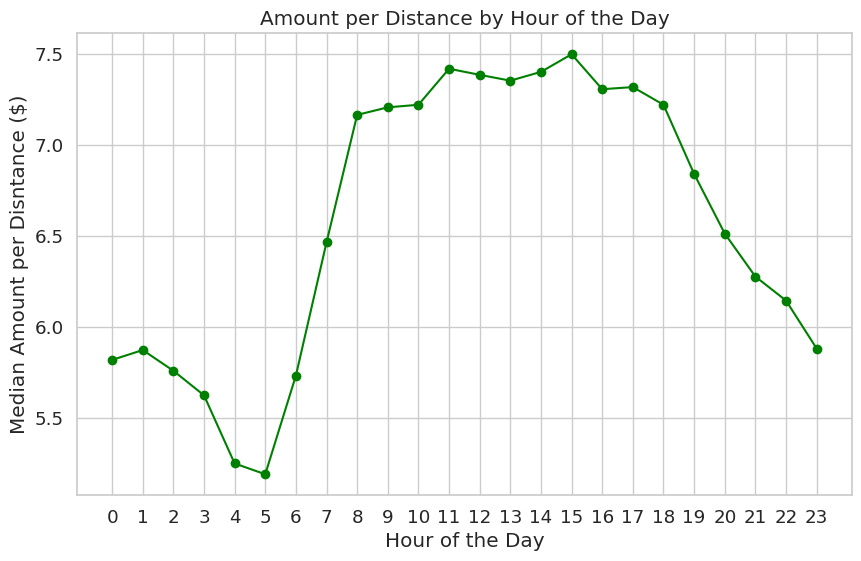

In [65]:
avg = pandas_time_df.groupby('hour')['Amount_per_Distance'].median()

plt.figure(figsize=(10, 6))
plt.plot(avg.index, avg.values, marker='o', color='green')
plt.title('Amount per Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Median Amount per Disntance ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## 4. Distribution of Payment Type by Locations & Months

+------------+------------+------+
|PULocationID|payment_type| count|
+------------+------------+------+
|         236|           1|216604|
|         175|           2|     6|
|         255|           3|    26|
|         195|           4|     2|
|           3|           0|     3|
|         256|           4|    34|
|          95|           2|   222|
|         146|           0|   190|
|         212|           1|    72|
|          80|           3|    23|
|         256|           1|  1050|
|         136|           1|   210|
|         214|           3|     1|
|         253|           2|     5|
|         243|           4|    20|
|          44|           3|     5|
|          88|           0|   488|
|         226|           2|  1631|
|          39|           3|    15|
|         139|           2|    16|
+------------+------------+------+
only showing top 20 rows

+------------+------------+------+
|DOLocationID|payment_type| count|
+------------+------------+------+
|         236|           1|23

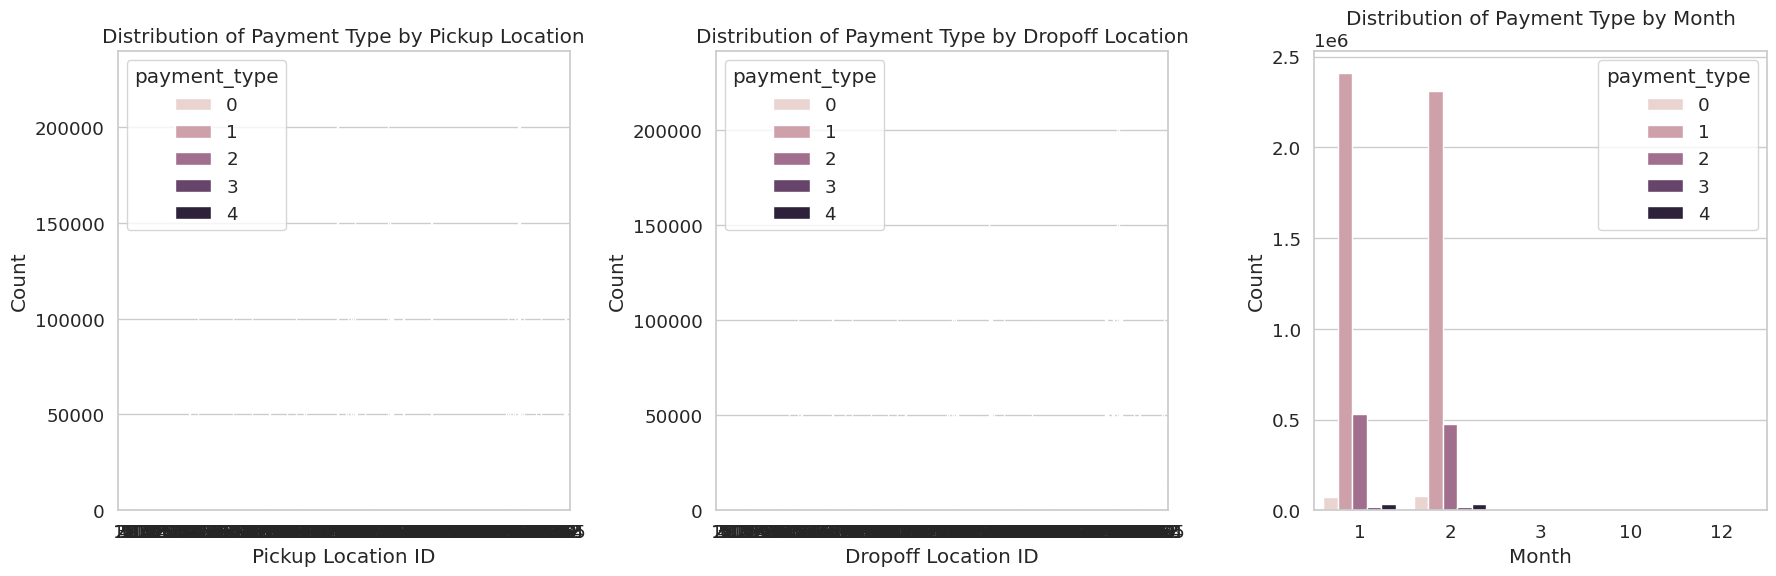

In [66]:
# Distribution of Payment_type by Pickup Location
pickup_location_distribution = df.groupBy("PULocationID", "payment_type").count()

# Distribution of Payment_type by Dropoff Location
dropoff_location_distribution = df.groupBy("DOLocationID", "payment_type").count()

# Distribution of Payment_type by Month
month_distribution = df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month", "payment_type").count()

# Show the distributions
pickup_location_distribution.show()
dropoff_location_distribution.show()
month_distribution.show()

# Plotting the distributions
plt.figure(figsize=(18, 6))

# Distribution by Pickup Location
plt.subplot(1, 3, 1)
sns.barplot(x="PULocationID", y="count", hue="payment_type", data=pickup_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Count')

# Distribution by Dropoff Location
plt.subplot(1, 3, 2)
sns.barplot(x="DOLocationID", y="count", hue="payment_type", data=dropoff_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Count')

# Distribution by Month
plt.subplot(1, 3, 3)
sns.barplot(x="month", y="count", hue="payment_type", data=month_distribution.toPandas())
plt.title('Distribution of Payment Type by Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [259]:
df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month").count().show()

+-----+-------+
|month|  count|
+-----+-------+
|   12|     31|
|    1|3066727|
|   10|     11|
|    2|2913910|
|    3|     42|
+-----+-------+



In [262]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double]

# Top 10 pickup locations & map

In [27]:
loc = pd.read_csv('yellow_taxi_data/taxi_zone_lookup.csv')

In [28]:
pudf = df.select('PULocationID','DOLocationID').cache()

In [29]:
from pyspark.sql.types import *
schema = StructType([
StructField("LocationID", StringType(), True),
StructField("Borough", StringType(), True),
StructField("Zone", StringType(), True),
StructField("service_zone", StringType(), True)])

locdf = spark.createDataFrame(loc, schema)

In [140]:
merged_doLoc = pudf.join(locdf, pudf.DOLocationID == locdf.LocationID, how = 'left')

In [141]:
loc_grouped = merged_doLoc.groupBy(['service_zone','Borough','Zone']).count().orderBy('count', ascending = False).toPandas()

In [142]:
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )

In [143]:
map_df['center'] = map_df.representative_point()

<Axes: title={'center': 'Density distribution of Dropoff location'}>

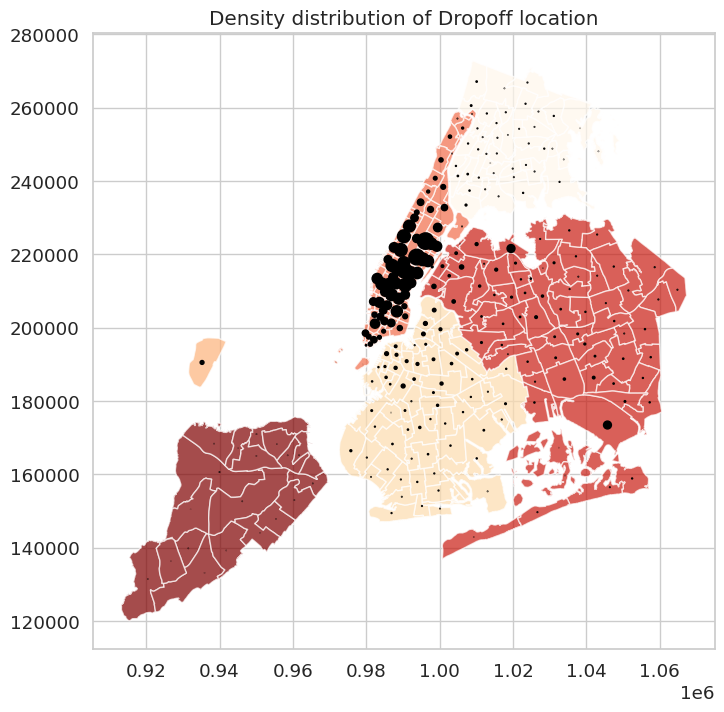

In [145]:
base = map_df.plot(figsize=(10,8), column='borough', alpha=0.7, cmap='OrRd')
base.set_title("Density distribution of Dropoff location")
max_size = 2000
min_size = 2
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=base, marker='o', color='black', markersize = 5*(map_df['count']/10000))

In [30]:
merged_puLoc = pudf.join(locdf, pudf.PULocationID == locdf.LocationID, how = 'left')

In [31]:
merged_puLoc.groupBy('service_zone').count().show()

+------------+-------+
|service_zone|  count|
+------------+-------+
|         EWR|    805|
|         NaN|  79317|
| Yellow Zone|5208811|
|    Airports| 465817|
|   Boro Zone| 225971|
+------------+-------+



In [32]:
merged_puLoc.groupBy('Zone').count().orderBy('count', ascending = False).show()

+--------------------+------+
|                Zone| count|
+--------------------+------+
|         JFK Airport|292124|
|Upper East Side S...|283020|
|      Midtown Center|270755|
|Upper East Side N...|264648|
|Penn Station/Madi...|213803|
|        Midtown East|207241|
|Times Sq/Theatre ...|196459|
| Lincoln Square East|193173|
|   LaGuardia Airport|173693|
|         Murray Hill|173351|
|       Midtown North|168874|
|Upper West Side S...|168559|
|        Clinton East|163045|
|            Union Sq|162537|
|     Lenox Hill West|154956|
|        East Village|152580|
|        East Chelsea|150167|
|       Midtown South|134015|
|        West Village|133478|
|            Gramercy|131563|
+--------------------+------+
only showing top 20 rows



In [33]:
merged_puLoc.groupBy('Borough').count().orderBy('count', ascending = False).show()

+-------------+-------+
|      Borough|  count|
+-------------+-------+
|    Manhattan|5319017|
|       Queens| 536322|
|      Unknown|  75075|
|     Brooklyn|  36307|
|        Bronx|   8351|
|          NaN|   4242|
|          EWR|    805|
|Staten Island|    602|
+-------------+-------+



In [34]:
loc_grouped = merged_puLoc.groupBy(['service_zone','Borough','Zone']).count().orderBy('count', ascending = False).toPandas()

In [136]:
loc_grouped.head()

service_zone    Borough                          Zone   count
0     Airports     Queens                   JFK Airport  292124
1  Yellow Zone  Manhattan         Upper East Side South  283020
2  Yellow Zone  Manhattan                Midtown Center  270755
3  Yellow Zone  Manhattan         Upper East Side North  264648
4  Yellow Zone  Manhattan  Penn Station/Madison Sq West  213803

In [36]:
# pip install geopandas

In [37]:
%matplotlib inline 
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


In [39]:
zone = gpd.read_file("yellow_taxi_data/taxi_zones/taxi_zones.shp")

In [134]:
zone.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...

In [54]:
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )

In [135]:
map_df.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...   

  service_zone        Borough                     Zone  count  \
0          EWR            EWR           Newark Airport    805   
1    Boro Zone         Queens              Jamaica Bay      4   
2    Boro Zone          Bronx  Allerton/Pelham Gardens     84   
3  Yellow Zone      Manhattan            Alphabet City   7396   
4    Boro Zone  Staten Island            Arden Heights    109   

                           center  
0   POINT (935223.027 190535.053)  
1  POINT (1032515.672 167292.493)  
2  POINT (1025882.735 254779.601)  
3   POINT (990618.795 203105.532)  
4   POINT (931467.963 139837.478)

In [103]:
map_df['center'] = map_df.representative_point()

<Axes: title={'center': 'Density distribution of pickup location'}>

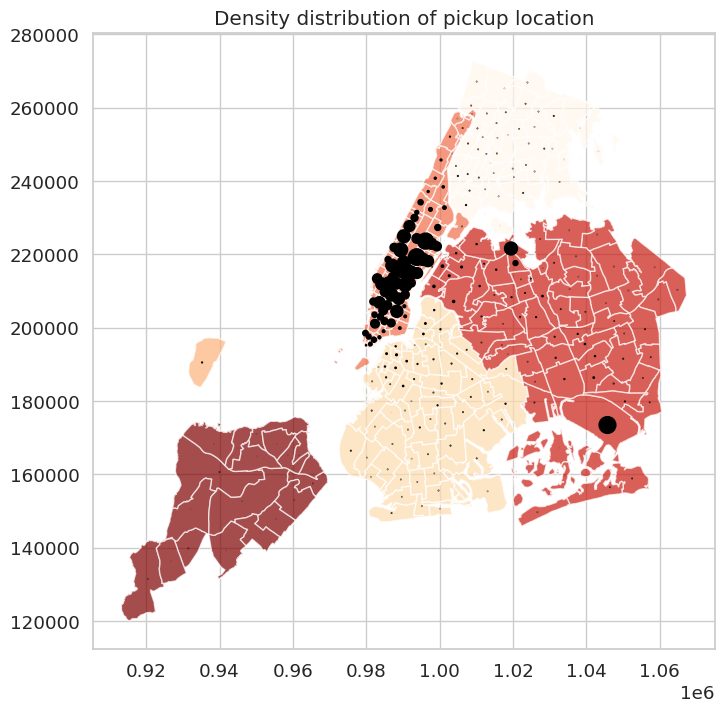

In [133]:
base = map_df.plot(figsize=(10,8), column='borough', alpha=0.7, cmap='OrRd')
base.set_title("Density distribution of pickup location")
max_size = 2000
min_size = 2
# rep_points.plot(ax=base, marker='o', color='black', markersize=min_size + (max_size-min_size)*(rep_points['pop_est']/pop_max));
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=base, marker='o', color='black', markersize = 5*(map_df['count']/10000))
# notice that markersize is not a constant; it is now computed based on other values
# this is a very simple way to scale points; other scaling functions can be used

<Axes: >

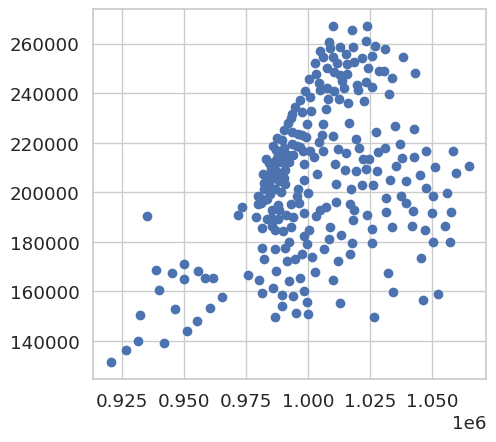

In [113]:
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot()

<Axes: >

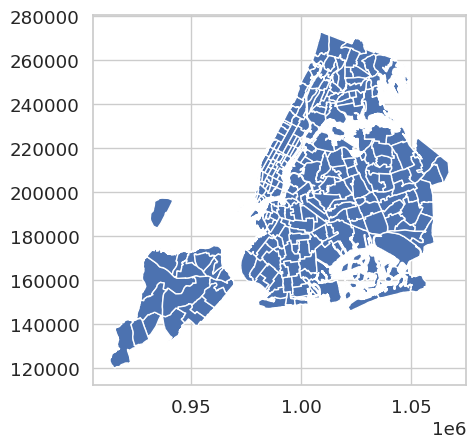

In [107]:
# map_df.plot()
map_df.set_geometry('center')
map_df.plot()

/scratch/hradhakrishnan/job_30371804/ipykernel_649313/2133469303.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Data Point Sizes')


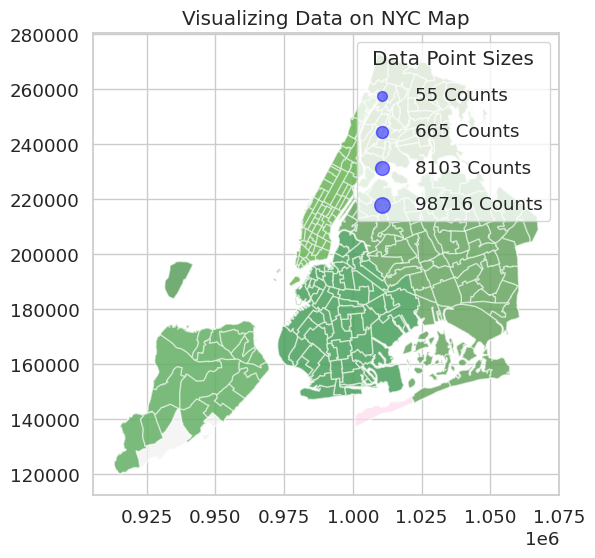

In [102]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'zone' is your GeoDataFrame for boroughs
# Assuming 'map_df' contains the data points with 'geometry' and 'count', and now 'marker_size'

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size as needed

# Plot boroughs with colors
zone.plot(ax=ax, column='borough', legend=True, legend_kwds={'title': "Boroughs of NYC"}, cmap='Pastel1', alpha=0.7)

marker_size = np.log(map_df['count'] + 1) * 10  # Adding 1 to avoid log(0)
map_df.plot(ax=ax, marker='o', color='green', markersize=marker_size, alpha=0.5, label='Data Points')

# Since we are using actual data for marker size, we can dynamically create a few representative markers for the legend
for size in [50, 75, 100, 125]:  # These sizes should correspond to meaningful data points or quartiles
    plt.scatter([], [], c='blue', alpha=0.5, s=size,
                label=f'{np.exp(size/10 - 1):.0f} Counts')  # Reverse the log to get approximate count values

plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Data Point Sizes')

plt.title("Visualizing Data on NYC Map")
plt.grid(True)
plt.show()


<Axes: >

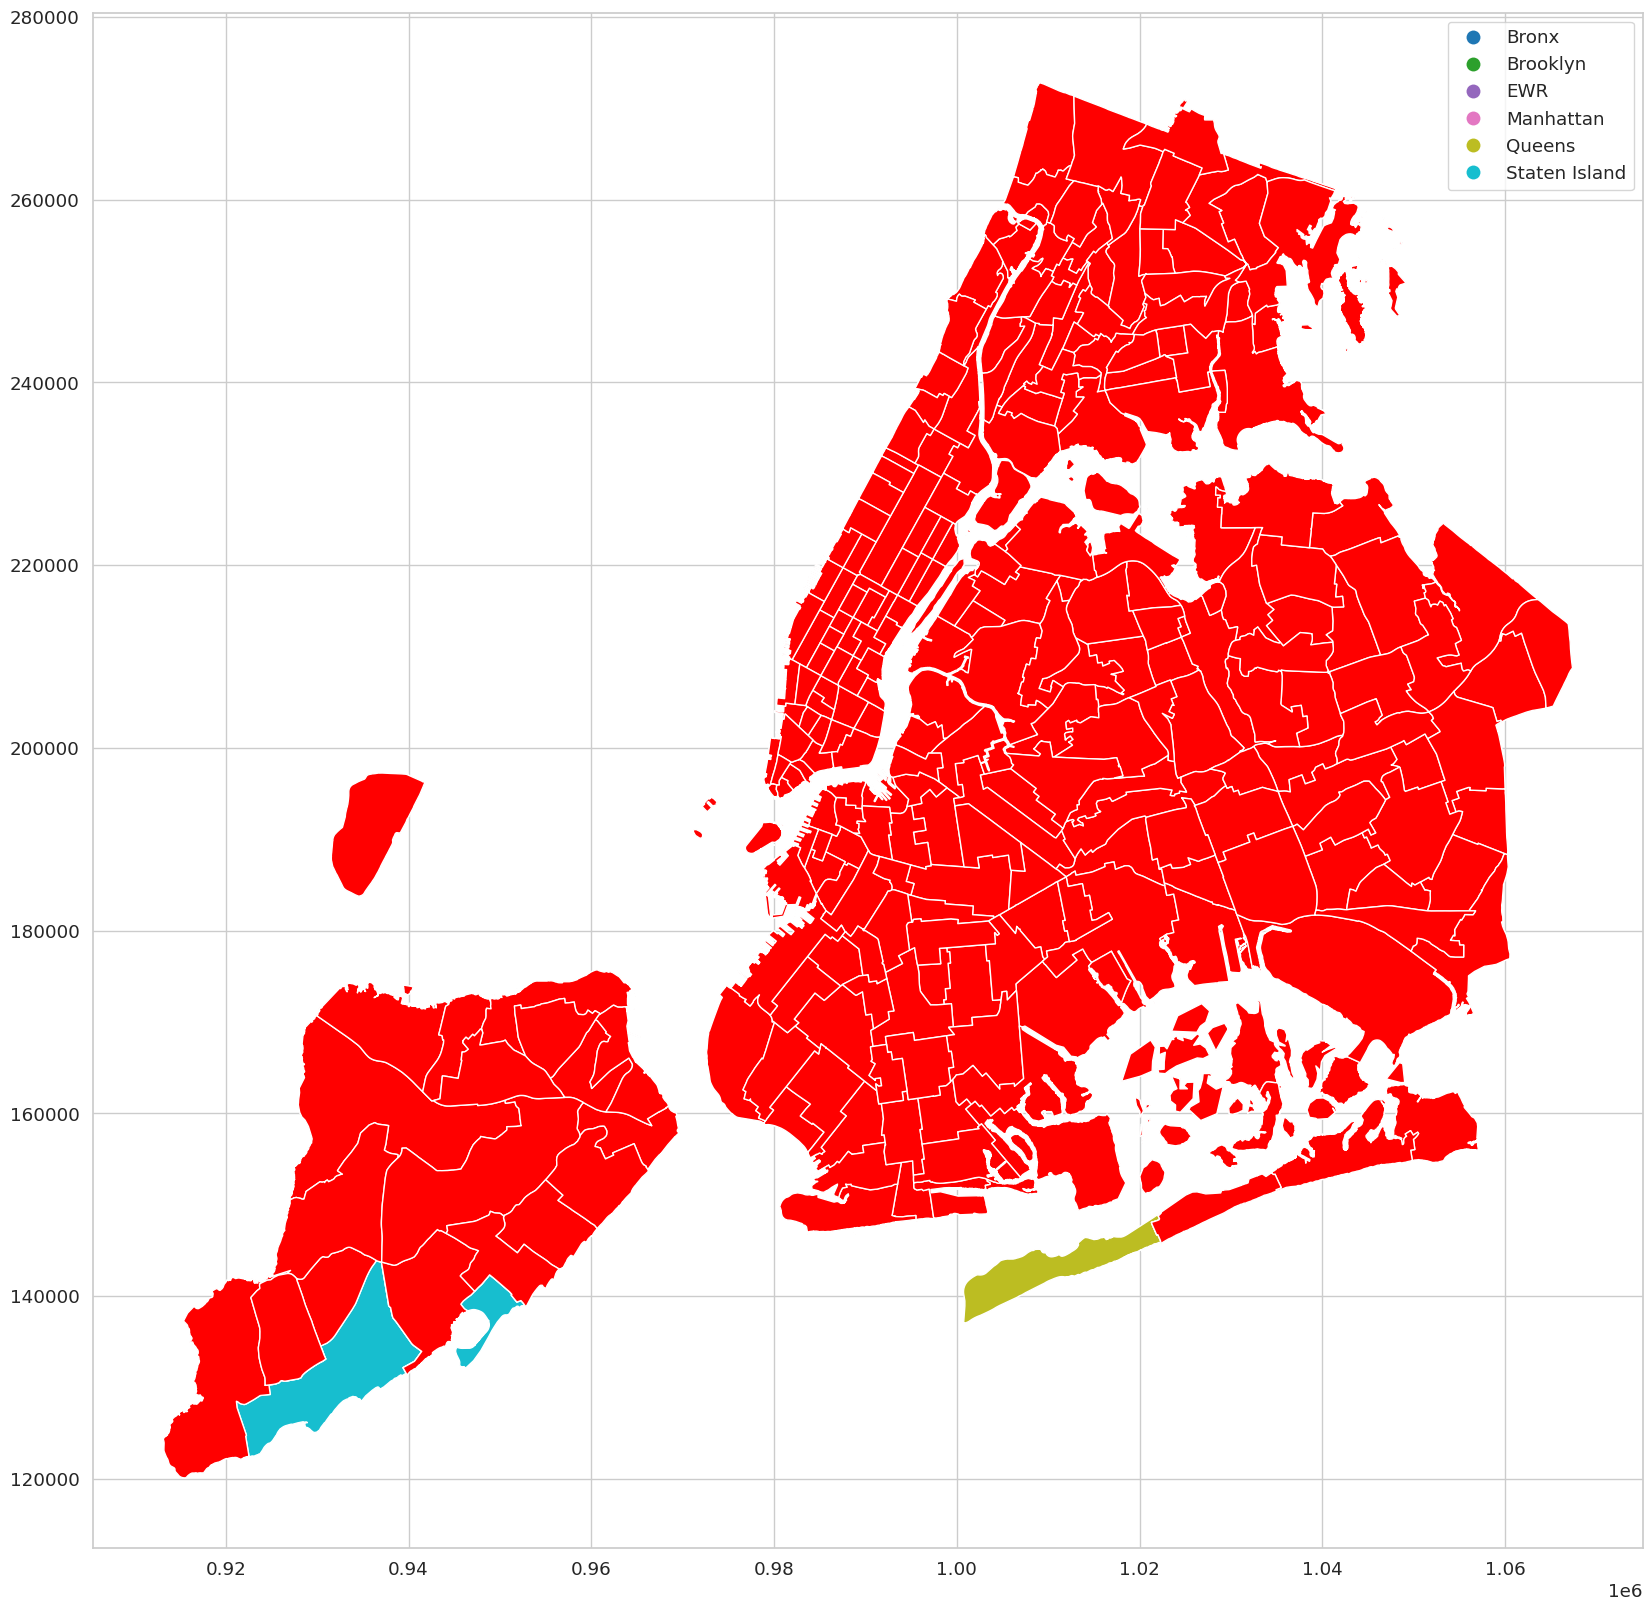

In [62]:
ny = zone.plot(column = 'borough', legend=True, figsize=(20,20))
map_df.plot(ax=ny, marker='o', color='red', markersize=map_df['count']/800)

In [46]:
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )

<Axes: >

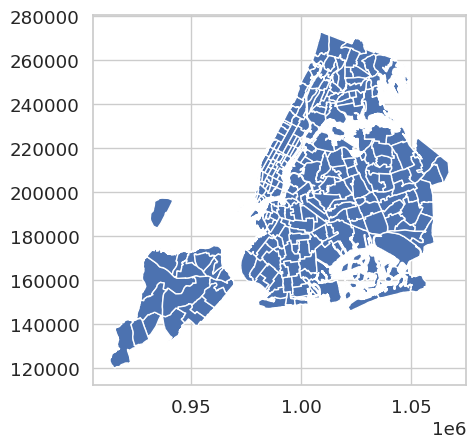

In [48]:
map_df.plot()

In [ ]:
pu_zone = gpd.sjoin(pudf, zone, how="inner", op="intersects")

In [290]:
pudf = locdf.groupby('PULocationID').count().orderBy('count', ascending = False)

In [291]:
dodf = locdf.groupby('DOLocationID').count().orderBy('count', ascending = False)

In [296]:
loc

LocationID        Borough                     Zone service_zone
0             1            EWR           Newark Airport          EWR
1             2         Queens              Jamaica Bay    Boro Zone
2             3          Bronx  Allerton/Pelham Gardens    Boro Zone
3             4      Manhattan            Alphabet City  Yellow Zone
4             5  Staten Island            Arden Heights    Boro Zone
..          ...            ...                      ...          ...
260         261      Manhattan       World Trade Center  Yellow Zone
261         262      Manhattan           Yorkville East  Yellow Zone
262         263      Manhattan           Yorkville West  Yellow Zone
263         264        Unknown                      NaN          NaN
264         265            NaN           Outside of NYC          NaN

[265 rows x 4 columns]

In [298]:
from pyspark.sql.types import *
schema = StructType([
StructField("LocationID", StringType(), True),
StructField("Borough", StringType(), True),
StructField("Zone", StringType(), True),
StructField("service_zone", StringType(), True)])

In [303]:
from pyspark.sql.types import *
schema = StructType([
StructField("LocationID", StringType(), True),
StructField("Borough", StringType(), True),
StructField("Zone", StringType(), True),
StructField("service_zone", StringType(), True)])

df3 = spark.createDataFrame(loc, schema)

In [309]:
merged_puLoc = pudf.join(df3, pudf.PULocationID == df3.LocationID, how = 'left')

In [310]:
merged_puLoc.show()

+------------+------+----------+---------+--------------------+------------+
|PULocationID| count|LocationID|  Borough|                Zone|service_zone|
+------------+------+----------+---------+--------------------+------------+
|          26|   202|        26| Brooklyn|        Borough Park|   Boro Zone|
|          29|   158|        29| Brooklyn|      Brighton Beach|   Boro Zone|
|          65|  3192|        65| Brooklyn|Downtown Brooklyn...|   Boro Zone|
|         191|   401|       191|   Queens|      Queens Village|   Boro Zone|
|         222|   260|       222| Brooklyn|       Starrett City|   Boro Zone|
|         243|   782|       243|Manhattan|Washington Height...|   Boro Zone|
|          54|    85|        54| Brooklyn|     Columbia Street|   Boro Zone|
|          19|   126|        19|   Queens|           Bellerose|   Boro Zone|
|         113| 80313|       113|Manhattan|Greenwich Village...| Yellow Zone|
|         112|  1164|       112| Brooklyn|          Greenpoint|   Boro Zone|

In [313]:
pudf.count()

260

In [311]:
merged_puLoc.groupBy('service_zone').count().show()

+------------+-----+
|service_zone|count|
+------------+-----+
|         EWR|    1|
|         NaN|    2|
| Yellow Zone|   53|
|    Airports|    2|
|   Boro Zone|  202|
+------------+-----+



In [292]:
loc = pd.read_csv('hradhakrishnan/yellow_taxi_data/taxi_zone_lookup.csv')

In [288]:
import pyspark.pandas as ps
from pyspark.sql import functions as F


In [137]:
# merged_loc = pudf.join(loc, F.col("pudf.PULocationID") == F.col("loc.LocationID"))


In [138]:
# merged = pudf.merge(loc, left_on='lkey', right_on='rkey')